In [80]:
# ============================================================
# 📦 Import libraries and basic setup
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: clean display
pd.set_option('display.max_columns', None)

In [ ]:
# ============================================================
# 📂 Load dataset
# ============================================================

file_path = "cleaned_dataset.csv"  # or your cleaned file if uploaded

df = pd.read_csv(file_path)
print("✅ Dataset loaded successfully!")
display(df.head())

print("\nColumns:", df.columns.tolist())

✅ Dataset loaded successfully!


,Age,Gender,Hypertension,Heart Disease,Smoking History,BMI,HbA1c,Random Glucose
0,17,1,0,0,0,18.89,1,2
1,38,1,0,0,2,26.29,1,0
2,45,0,1,0,1,26.00,2,3
3,80,1,0,0,2,32.76,2,3
4,50,1,0,0,0,35.00,1,0



Columns: ['Age', 'Gender', 'Hypertension', 'Heart Disease', 'Smoking History', 'BMI', 'HbA1c', 'Random Glucose']


In [83]:
# ============================================================
# 🧹 Data preprocessing & encoding
# ============================================================

# Drop irrelevant columns if present
cols_to_drop = [col for col in ["index", "medical_note"] if col in df.columns]
df = df.drop(columns=cols_to_drop, errors="ignore")

# Ensure target column exists
if "has_diabetes" not in df.columns:
    raise ValueError("❌ The dataset must contain a 'has_diabetes' column for training.")

# Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include=["object", "category"]).columns:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle missing values
df = df.fillna(df.median(numeric_only=True))

display(df.head())
print("\n✅ Encoded and cleaned data ready for training.")

ValueError: ❌ The dataset must contain a 'has_diabetes' column for training.

In [69]:
# ============================================================
# 📊 Split data into training and testing sets
# ============================================================

X = df.drop(columns=["has_diabetes"])
y = df["has_diabetes"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples:  {X_test.shape[0]}")

Training samples: 1284
Testing samples:  321


In [70]:
# ============================================================
# ⚙️ Fine-tuning setup
# ============================================================

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Optional: XGBoost & LightGBM
try:
    import xgboost as xgb
    has_xgboost = True
except (ImportError, OSError):
    has_xgboost = False
    print("⚠️ XGBoost not available.")

try:
    import lightgbm as lgb
    has_lightgbm = True
except (ImportError, OSError):
    has_lightgbm = False
    print("⚠️ LightGBM not available.")

# Define parameter grids for each model
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [5, 10, 15, None],
        "min_samples_split": [2, 5, 10],
        "class_weight": ["balanced"]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7]
    },
    "Logistic Regression": {
        "C": [0.1, 1, 10, 100],
        "solver": ["lbfgs", "liblinear"],
        "class_weight": ["balanced"]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf", "poly"],
        "class_weight": ["balanced"]
    },
    "Neural Net": {
        "hidden_layer_sizes": [(64,), (64, 32), (128, 64, 32)],
        "activation": ["relu", "tanh"],
        "learning_rate_init": [0.001, 0.01],
        "max_iter": [300, 600]
    }
}

if has_xgboost:
    param_grids["XGBoost"] = {
        "n_estimators": [200, 300, 400],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 6, 8],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0]
    }

if has_lightgbm:
    param_grids["LightGBM"] = {
        "n_estimators": [200, 300, 400],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 6, 8, -1],
        "num_leaves": [15, 31, 63]
    }

In [71]:
# ============================================================
# 🧠 Fine-tune models using GridSearchCV / RandomizedSearchCV
# ============================================================

from sklearn.metrics import f1_score

best_models = {}
results = []

# Models to fine-tune
models_to_tune = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    #"SVM": SVC(probability=True, random_state=42),
    "Neural Net": MLPClassifier(random_state=42)
}

if has_xgboost:
    models_to_tune["XGBoost"] = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

if has_lightgbm:
    models_to_tune["LightGBM"] = lgb.LGBMClassifier(random_state=42)

# Run tuning
for name, model in models_to_tune.items():
    print(f"\n🔹 Fine-tuning {name}...")
    params = param_grids[name]
    
    # Use RandomizedSearch for efficiency on large spaces
    search = RandomizedSearchCV(
        model,
        params,
        n_iter=10,  # You can increase this for deeper tuning
        scoring="f1",
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X_train, y_train)
    
    best_models[name] = search.best_estimator_
    y_pred = search.best_estimator_.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "F1 Score": f1,
        "Accuracy": search.best_estimator_.score(X_test, y_test)
    })
    
    print(f"✅ {name} — Best F1: {f1:.4f}")

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
results_df


🔹 Fine-tuning Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Random Forest — Best F1: 0.7489

🔹 Fine-tuning Gradient Boosting...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Gradient Boosting — Best F1: 0.7065

🔹 Fine-tuning Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Logistic Regression — Best F1: 0.7328

🔹 Fine-tuning Neural Net...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Neural Net — Best F1: 0.6220

🔹 Fine-tuning XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ XGBoost — Best F1: 0.7174

🔹 Fine-tuning LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 265, number of negative: 591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wi

,Model,Best Params,F1 Score,Accuracy
5,LightGBM,"{'num_leaves': 15, 'n_estimators': 300, 'max_d...",0.750000,0.856698
0,Random Forest,"{'n_estimators': 300, 'min_samples_split': 10,...",0.748899,0.822430
2,Logistic Regression,"{'solver': 'lbfgs', 'class_weight': 'balanced'...",0.732759,0.806854
4,XGBoost,"{'subsample': 1.0, 'n_estimators': 300, 'max_d...",0.717391,0.838006
1,Gradient Boosting,"{'n_estimators': 100, 'max_depth': 3, 'learnin...",0.706522,0.831776
3,Neural Net,"{'max_iter': 600, 'learning_rate_init': 0.001,...",0.621951,0.806854


🏆 Best Model: LightGBM

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       222
           1       0.76      0.68      0.72        99

    accuracy                           0.83       321
   macro avg       0.81      0.79      0.80       321
weighted avg       0.83      0.83      0.83       321



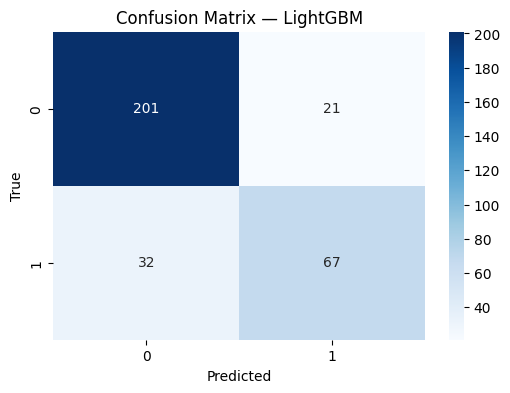

In [72]:
# ============================================================
# 📊 Confusion Matrix for Best Model
# ============================================================

best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

print(f"🏆 Best Model: {best_model_name}")

# Predictions
y_pred_best = best_model.predict(X_test)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [76]:
# ============================================================
# 🧠 Train and Save Diabetes Prediction Model
# ============================================================

import joblib

# Example: using the best fine-tuned model
# (Replace with your best model variable)
model = best_models[best_model_name]  
model.fit(X_train, y_train)  # Train on full data

# Save trained model
joblib.dump(model, "diabetes_model.pkl")
print("✅ Model trained and saved as 'diabetes_model.pkl'")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 398, number of negative: 886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 1284, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.309969 -> initscore=-0.800265
[LightGBM] [Info] Start training from score -0.800265
✅ Model trained and saved as 'diabetes_model.pkl'


In [77]:
# ============================================================
# 🔮 Predict diabetes for a new patient (with numeric mappings)
# ============================================================

import pandas as pd
import joblib

# Example row (replace values with your input)
new_patient = {
    "Age": 45,
    "Gender": "Male",
    "Hypertension": 1,
    "Heart Disease": 0,
    "Smoking History": "past",
    "BMI": 31.2,
    "HbA1c": 6.5,
    "Random Glucose": 180.0
}

# ------------------------------------------------------------
# Load trained model
# ------------------------------------------------------------
model = joblib.load("diabetes_model.pkl")

# ------------------------------------------------------------
# Mapping functions
# ------------------------------------------------------------

def encode_gender(g):
    return 0 if str(g).lower() == "male" else 1

def encode_smoking_history(s):
    mapping = {"never": 0, "current": 1, "past": 2}
    return mapping.get(str(s).lower(), 0)

def encode_hba1c(x):
    if pd.isna(x): return 1
    if 0 < x < 4: return 0
    elif 4 <= x < 5.6: return 1
    elif 5.6 <= x < 6.4: return 2
    elif 6.4 <= x < 7: return 3
    elif 7 <= x < 15: return 4
    else: return 1

def encode_glucose(x):
    if pd.isna(x): return 1
    if 30 < x < 70: return 0
    elif 70 <= x < 140: return 1
    elif 140 <= x < 200: return 2
    elif 200 <= x < 500: return 3
    else: return 1

# ------------------------------------------------------------
# Encode patient data
# ------------------------------------------------------------
processed = new_patient.copy()
processed["Gender"] = encode_gender(processed["Gender"])
processed["Smoking History"] = encode_smoking_history(processed["Smoking History"])
processed["HbA1c"] = encode_hba1c(processed["HbA1c"])
processed["Random Glucose"] = encode_glucose(processed["Random Glucose"])

input_df = pd.DataFrame([processed])

# ------------------------------------------------------------
# Predict
# ------------------------------------------------------------
prediction = model.predict(input_df)[0]
prob = model.predict_proba(input_df)[0][1] if hasattr(model, "predict_proba") else None

result = "🩸 Has Diabetes" if prediction == 1 else "✅ No Diabetes"

print(f"\nPrediction: {result}")
if prob is not None:
    print(f"Confidence: {prob:.2%}")


Prediction: ✅ No Diabetes
Confidence: 25.98%


In [ ]:
# ============================================================
# 🔮 Predict Diabetes for All Patients in Cleaned Dataset
# ============================================================

import pandas as pd
import joblib

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
MODEL_PATH = "diabetes_model.pkl"
DATA_PATH = "../cleaned_dataset.csv"
OUTPUT_PATH = "predictions.csv"

# ------------------------------------------------------------
# Load model and dataset
# ------------------------------------------------------------
print("📂 Loading model and dataset...")
model = joblib.load(MODEL_PATH)
df = pd.read_csv(DATA_PATH)
print(f"✅ Loaded dataset with {df.shape[0]} patients and {df.shape[1]} columns.")

# ------------------------------------------------------------
# Determine ID column
# ------------------------------------------------------------
id_column = None
if "patient_id" in df.columns:
    id_column = "patient_id"
elif "Index" in df.columns:
    id_column = "Index"
else:
    print("⚠️ No ID column found, generating patient IDs automatically...")
    df["patient_id"] = [f"patient_{i:05d}" for i in range(1, len(df) + 1)]
    id_column = "patient_id"

# ------------------------------------------------------------
# Ensure feature columns exist
# ------------------------------------------------------------
required_features = [
    "Age", "Gender", "Hypertension", "Heart Disease",
    "Smoking History", "BMI", "HbA1c", "Random Glucose"
]

missing_features = [col for col in required_features if col not in df.columns]
if missing_features:
    raise ValueError(f"❌ Missing feature columns: {missing_features}")

# ------------------------------------------------------------
# Predict diabetes
# ------------------------------------------------------------
X = df[required_features]
predictions = model.predict(X)

# ------------------------------------------------------------
# Build results table
# ------------------------------------------------------------
results = pd.DataFrame({
    "patient_id": df[id_column],
    "has_diabetes": predictions.astype(int)
})

# ------------------------------------------------------------
# Preview & save
# ------------------------------------------------------------
print("\n✅ Predictions complete! Sample results:")
print(results.head())

results.to_csv(OUTPUT_PATH, index=False)
print(f"\n📁 Predictions saved to: {OUTPUT_PATH}")

📂 Loading model and dataset...
✅ Loaded dataset with 300 patients and 9 columns.

✅ Predictions complete! Sample results:
   patient_id  has_diabetes
0       37551             0
1       24430             0
2       89346             1
3       88818             1
4         139             0

📁 Predictions saved to: predictions.csv


In [ ]:
# ============================================================
# 📦 Predict diabetes for a batch of patients (no has_diabetes)
# ============================================================

# Example: assume you have a new CSV without `has_diabetes`
# new_data = pd.read_csv("/kaggle/input/new-patients.csv")

# For demo, we'll just reuse part of df
new_data = X_test.sample(5, random_state=42)
predictions = model.predict(new_data)

new_data["Predicted_has_diabetes"] = predictions
display(new_data)

,Age,Gender,Hypertension,Heart Disease,Smoking History,BMI,HbA1c,Random Glucose,Predicted_has_diabetes
1489,80.0,1,0.0,0.0,2,33.73,0.0,1.0,0
1469,80.0,1,0.0,0.0,0,21.87,3.0,1.0,0
190,71.0,0,0.0,0.0,0,33.00,2.0,2.0,0
263,61.0,0,1.0,0.0,2,27.32,0.0,3.0,0
582,40.0,1,0.0,0.0,0,23.32,4.0,1.0,0
